In [1]:
import sys
root_dir_abspath = '/home/adnen.boumessouer/Anomaly_Detection'

In [2]:
sys.path.insert(0, root_dir_abspath)

In [3]:
import os

import numpy as np
import pandas as pd
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt

from modules.resmaps import calculate_resmaps
from modules.cv import threshold_images
from modules.cv import label_images

from modules.utils import printProgressBar as printProgressBar
import time

from sklearn.metrics import confusion_matrix
from modules import utils as utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
def plot_image(image, cmap="inferno", title=None):
    fig, ax = plt.subplots(figsize=(5, 3))
    im = ax.imshow(image, cmap=cmap)
    ax.set_axis_off()
    fig.colorbar(im)
    plt.title(title)
    plt.show()

## Load arrays
to create these arrays, you either need to have run `train.py` with `--inspect` flag, or run `validation.py` and `test.py` (with dummy `area` and `threshold` arguments) and set the `--save` flag for both.

### Load validation and test (input and pred) images

In [5]:
# change model_dir to try another model 
model_dir = "saved_models/mvtec/transistor/mvtec2/SSIM/17-05-2020_14-17-53"

model_abs_path = os.path.join(root_dir_abspath, model_dir)

# change paths if input and pred images are not stored in .../instection
path_val_input = os.path.join(model_abs_path, "inspection_val/imgs_val_input.npy")
path_val_pred = os.path.join(model_abs_path, "inspection_val/imgs_val_pred.npy")

imgs_val_input = np.load(path_val_input, allow_pickle=True)
imgs_val_pred = np.load(path_val_pred, allow_pickle=True)

path_test_input = os.path.join(model_abs_path, "inspection_test/imgs_test_input.npy")
path_test_pred = os.path.join(model_abs_path, "inspection_test/imgs_test_pred.npy")

imgs_test_input = np.load(path_test_input, allow_pickle=True)
imgs_test_pred = np.load(path_test_pred, allow_pickle=True)

## Calculate Resmaps

In [6]:
resmaps_val_ssim = calculate_resmaps(imgs_val_input, imgs_val_pred, method="SSIM")
resmaps_val = img_as_ubyte(resmaps_val_ssim)

resmaps_test_ssim = calculate_resmaps(imgs_test_input, imgs_test_pred, method="SSIM")
resmaps_test = img_as_ubyte(resmaps_test_ssim)

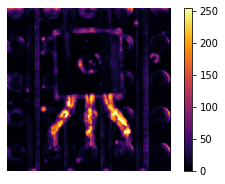

In [7]:
index_val = 0
plot_image(resmaps_val[index_val,:,:,0])

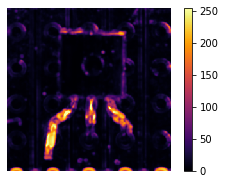

In [8]:
index_test = 0
plot_image(resmaps_test[index_test,:,:,0])

# Simulate Validation in `validation.py`

In [9]:
def calculate_thresholds_from_areas(resmaps_val, min_areas, th_min=128):
    # initialize validation dictionary
    dict_val = {"min_area": [], "threshold": []}
    
    th_max = np.amax(resmaps_val)
    
    # initialize progress bar
    l = len(min_areas)
    printProgressBar(0, l, prefix="Progress:", suffix="Complete", length=50)
    
    # loop over all min_areas and compute corresponding thresholds
    for i, min_area in enumerate(min_areas):
    
        for threshold in range(th_min, th_max + 1):
            # threshold residual maps
            resmaps_th = threshold_images(resmaps_val, threshold)[:,:,:,0]
    
            # compute connected components
            resmaps_labeled, areas_all = label_images(resmaps_th)
    
            # check if area of largest anomalous region is below the minimum area
            areas_all_flat = [item for sublist in areas_all for item in sublist]
            areas_all_flat.sort(reverse=True)
            try:
                if min_area > areas_all_flat[0]:
                    break
            except IndexError:
                continue
    
        # print progress bar
        time.sleep(0.1)
        printProgressBar(i + 1, l, prefix="Progress:", suffix="Complete", length=50)
    
        # append min_area and corresponding threshold to validation dictionary
        dict_val["min_area"].append(min_area)
        dict_val["threshold"].append(threshold)
        
        # create a list containing (min_area, threshold) pairs
        elems_val = list(zip(dict_val["min_area"], dict_val["threshold"]))       
        
    return dict_val, elems_val


#### Simulate validation script with multiple `min_area` input arguments

In [10]:
min_areas = np.arange(start=0, stop=500, step=5)   
dict_val, elems_val = calculate_thresholds_from_areas(resmaps_val, min_areas, th_min=170)
df_val = pd.DataFrame.from_dict(dict_val)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [11]:
df_val

,min_area,threshold
0,0,255
1,5,255
2,10,255
3,15,255
4,20,255
...,...,...
95,475,209
96,480,209
97,485,209
98,490,209


# Simulate Classification in `test.py`

In [12]:
# CLASSIFICATION

def is_defective(areas, min_area):
    """Decides if image is defective given the areas of its connected components"""
    areas = np.array(areas)
    if areas[areas >= min_area].shape[0] > 0:
        return 1
    return 0


def classify(areas_all, min_area):
    """Decides if images are defective given the areas of their connected components"""
    y_pred = []
    for areas in areas_all:
        y_pred.append(is_defective(areas, min_area))
    return y_pred


def calculate_detection_ratios(test_data_dir, resmaps_test, elems):
    
    test_datagen = ImageDataGenerator(
        rescale=None,
        data_format="channels_last",
        preprocessing_function=None,
    )
    
    total_number = utils.get_total_number_test_images(test_data_dir)
    
    # retrieve preprocessed test images as a numpy array
    test_generator = test_datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(256,256),
        color_mode="grayscale",
        batch_size=total_number,
        shuffle=False,
        class_mode=None,
    )
    
    filenames = test_generator.filenames
    
    # initialize dictionary to store test results
#     dict_test = {"min_area": [], "threshold": [], "TPR": [], "TNR": [], "score":[]}
    dict_test = {"min_area": [], "threshold": [], "TPR": [], "TNR": [], "FPR": [], "FNR": [], "score":[]}
    # initialize progress bar
    l = len(elems)
    printProgressBar(0, l, prefix="Progress:", suffix="Complete", length=50)
    
    # classify test images for all (min_area, threshold) pairs
    for i, elem in enumerate(elems):
        # get (min_area, threshold) pair
        min_area, threshold = elem[0], elem[1]
    
        # threshold residual maps with the given threshold
        resmaps_th = threshold_images(resmaps_test, threshold)[:,:,:,0]
    
        # compute connected components
        resmaps_labeled, areas_all = label_images(resmaps_th)
    
        # classify images
        y_pred = classify(areas_all, min_area)
    
        # retrieve ground truth
        y_true = [
            1 if "good" not in filename.split("/") else 0 for filename in filenames
        ]

        # condition positive (P)
        P = y_true.count(1)
    
        # condition negative (N)
        N = y_true.count(0)
    
        # true positive (TP)
        TP = np.sum([1 if y_pred[i] == y_true[i] == 1 else 0 for i in range(total_number)])
        
        # false positive (FP)
        FP = np.sum([1 if (y_pred[i] == 0 and y_true[i] == 1) else 0 for i in range(total_number)])
    
        # true negative (TN)
        TN = np.sum([1 if y_pred[i] == y_true[i] == 0 else 0 for i in range(total_number)])
        
        # false negative (FN)
        FN = np.sum([1 if (y_pred[i] == 1 and y_true[i] == 0) else 0 for i in range(total_number)])
        
        # sensitivity, recall, hit rate, or true positive rate (TPR)
        TPR = TP / P
    
        # specificity, selectivity or true negative rate (TNR)
        TNR = TN / N
        
        # compute score (mean of TPR and TNR)
        score = (TPR + TNR)/2
    
        # confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, normalize="true").ravel()
    
        # append test results to dictionary
        dict_test["min_area"].append(min_area)
        dict_test["threshold"].append(threshold)
        dict_test["TPR"].append(tp)
        dict_test["TNR"].append(tn)
        dict_test["FPR"].append(fp)
        dict_test["FNR"].append(fn)
        dict_test["score"].append(score)
    
        # print progress bar
        time.sleep(0.1)
        printProgressBar(i + 1, l, prefix="Progress:", suffix="Complete", length=50)
    
    return dict_test

In [13]:
def get_classification(test_data_dir, resmaps_test, elem):
    
    test_datagen = ImageDataGenerator(
        rescale=None,
        data_format="channels_last",
        preprocessing_function=None,
    )
    
    total_number = utils.get_total_number_test_images(test_data_dir)
    
    # retrieve preprocessed test images as a numpy array
    test_generator = test_datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(256,256),
        color_mode="grayscale",
        batch_size=total_number,
        shuffle=False,
        class_mode=None,
    )
    
    # get filenames
    filenames = test_generator.filenames    
    
    # classify test images for best (min_area, threshold) pair

    # get (min_area, threshold) pair
    min_area, threshold = elem[0], elem[1]

    # threshold residual maps with the given threshold
    resmaps_th = threshold_images(resmaps_test, threshold)[:,:,:,0]

    # compute connected components
    resmaps_labeled, areas_all = label_images(resmaps_th)

    # classify images
    y_pred = classify(areas_all, min_area)

    # retrieve ground truth
    y_true = [
        1 if "good" not in filename.split("/") else 0 for filename in filenames
    ]

    # save classification of image files in a .txt file
    classification = {
        "filenames": filenames,
        "predictions": y_pred,
        "truth": y_true,
    }
    df_clf = pd.DataFrame.from_dict(classification)

    # condition positive (P)
    P = y_true.count(1)

    # condition negative (N)
    N = y_true.count(0)

    # true positive (TP)
    TP = np.sum([1 if y_pred[i] == y_true[i] == 1 else 0 for i in range(total_number)])

    # true negative (TN)
    TN = np.sum([1 if y_pred[i] == y_true[i] == False else 0 for i in range(total_number)])

    # sensitivity, recall, hit rate, or true positive rate (TPR)
    TPR = TP / P
    print("TPR = {}".format(TPR))

    # specificity, selectivity or true negative rate (TNR)
    TNR = TN / N
    print("TNR = {}".format(TNR))

    # compute score (mean of TPR and TNR)
    score = (TPR + TNR)/2
    print("score = {}".format(score))

    return df_clf

### Test with validation (min_area, threshold) pairs

In [14]:
test_data_dir = "mvtec/transistor/test"
test_data_dir_abspath = os.path.join(root_dir_abspath, test_data_dir)

In [15]:
test_data_dir_abspath

'/home/adnen.boumessouer/Anomaly_Detection/mvtec/transistor/test'

In [16]:
dict_test_from_val = calculate_detection_ratios(test_data_dir_abspath, resmaps_test, elems_val)
result_test_from_val = pd.DataFrame.from_dict(dict_test_from_val)

Found 100 images belonging to 5 classes.
Progress: |██████████████████████████████████████████████████| 100.0% Complete


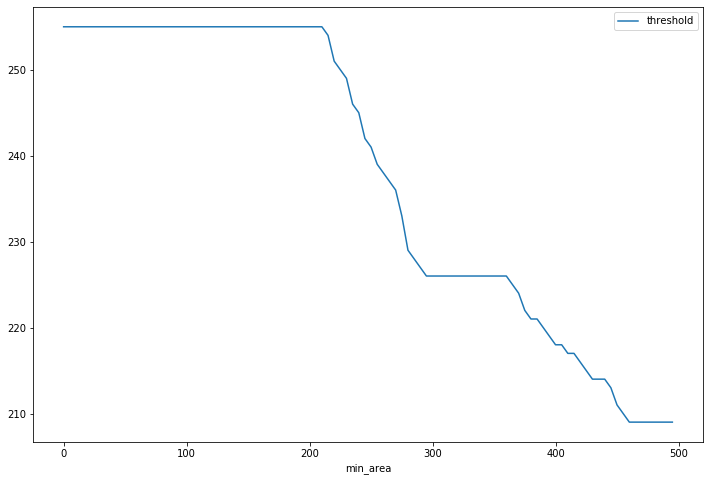

In [17]:
result_test_from_val.plot(x="min_area", y=["threshold"], figsize=(12,8))

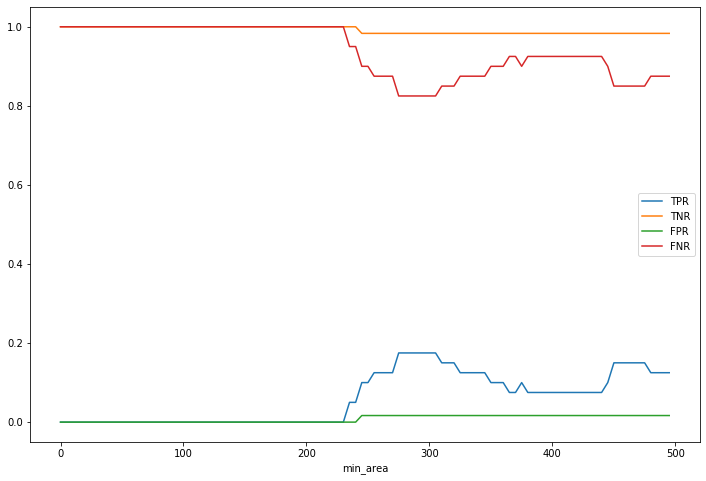

In [18]:
result_test_from_val.plot(x="min_area", y=["TPR","TNR","FPR","FNR"], figsize=(12,8))

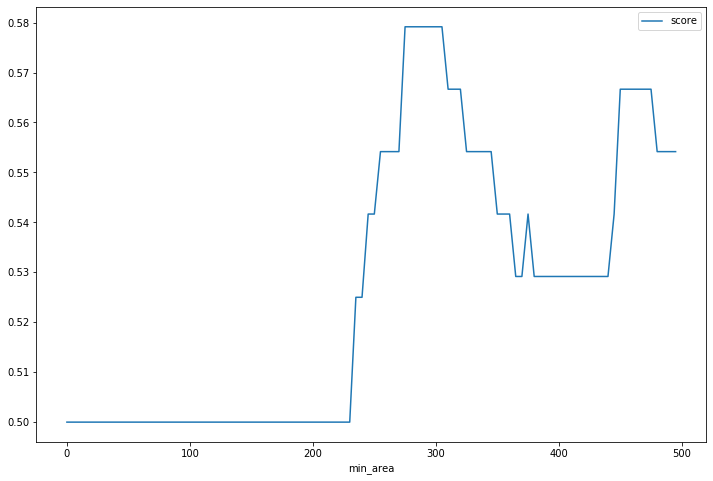

In [19]:
ax = result_test_from_val.plot(x="min_area", y=["score"], figsize=(12,8))

In [20]:
ax.figure.savefig(os.path.join(root_dir_abspath, "report", "plots", "scores.png"))

In [21]:
result_test_from_val.sort_values(by=["min_area", "threshold"], inplace=True)
result_test_from_val

,min_area,threshold,TPR,TNR,FPR,FNR,score
0,0,255,0.000,1.000000,0.000000,1.000,0.500000
1,5,255,0.000,1.000000,0.000000,1.000,0.500000
2,10,255,0.000,1.000000,0.000000,1.000,0.500000
3,15,255,0.000,1.000000,0.000000,1.000,0.500000
4,20,255,0.000,1.000000,0.000000,1.000,0.500000
...,...,...,...,...,...,...,...
95,475,209,0.150,0.983333,0.016667,0.850,0.566667
96,480,209,0.125,0.983333,0.016667,0.875,0.554167
97,485,209,0.125,0.983333,0.016667,0.875,0.554167
98,490,209,0.125,0.983333,0.016667,0.875,0.554167


### Show best result based on score

In [22]:
df_best_result = result_test_from_val.sort_values(by=["score"], inplace=False).iloc[[-1]]
df_best_result

,min_area,threshold,TPR,TNR,FPR,FNR,score
58,290,227,0.175,0.983333,0.016667,0.825,0.579167


## Get Classification

In [23]:
best_min_area = df_best_result["min_area"].values[0]
best_threshold = df_best_result["threshold"].values[0]
best_elem = (best_min_area, best_threshold)
print(best_elem)

(290, 227)


In [24]:
df_clf = get_classification(test_data_dir_abspath, resmaps_test, best_elem)

Found 100 images belonging to 5 classes.
TPR = 0.175
TNR = 0.9833333333333333
score = 0.5791666666666666


In [25]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(df_clf)

               filenames  predictions  truth
0      bent_lead/000.png            0      1
1      bent_lead/001.png            0      1
2      bent_lead/002.png            0      1
3      bent_lead/003.png            0      1
4      bent_lead/004.png            0      1
5      bent_lead/005.png            0      1
6      bent_lead/006.png            0      1
7      bent_lead/007.png            0      1
8      bent_lead/008.png            1      1
9      bent_lead/009.png            0      1
10      cut_lead/000.png            0      1
11      cut_lead/001.png            0      1
12      cut_lead/002.png            0      1
13      cut_lead/003.png            0      1
14      cut_lead/004.png            0      1
15      cut_lead/005.png            0      1
16      cut_lead/006.png            0      1
17      cut_lead/007.png            0      1
18      cut_lead/008.png            0      1
19      cut_lead/009.png            0      1
20  damaged_case/000.png            0      1
21  damage

-----------------------------------